# Reinforcement Learning of Social Distancing during COVID-19 with a Confounder

## Overview

Given a problem, the objective of reinforcement learning is to choose an optimal policy that maximizes expected reward over time. In other words, it takes for granted that we can learn a direct cause-effect relationship between following a particular policy and receiving a reward. However, an understanding of the principles of causality will tell you that this direct relationship is not always so easy to estimate. The aim of this project is to investigate the impact of a backdoor path through a causal confounder on reinforcement learning performance. We chose to use a relevant example of a social distancing policy during COVID-19 to illustrate this concept. We expect to find that an agent that learns a policy without adjusting for a confounder will perform disproportionately worse than adjusted policies.

## COVID-19 Model

We use an SEIHRD (Susceptible-Exposed-Infected-Hospitalized-Recovered or Dead) epidemic model to model the spread of COVID-19. An agent is assumed to be in one of the possible states at any given time-step, and transitions from one state to another with a given parameter governed by a set of differential equations.

The different states and possible transitions are described in the diagram below:


<img style="float: center;" src="figs/SEIRDH.png">

## Importing requirements

In [1]:
import os
import sys
import itertools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2
from itertools import product

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.style.use('seaborn-poster')
import seaborn as sns
import numpy as np

import whynot.gym as gym
import utils

%matplotlib inline
import simulators.covid19 as covid19
import simulators.covid19.environments.starter_env

## Starter environment

This environment helps us demonstrate our basic COVID-19 environment.

### State space

In line with our SEIRHD Model, the state space for our problem consists of:
- Susceptible
- Exposed
- Infected
- Recovered 
- Hospitalized
- Dead

### Transitions

We can only transition from one state to another in the order dictated by the acronym SEIRHD. We cannot jump around from Dead to Infected, or Recovered to Exposed, for instance.

### Action space

We chose a discrete action space with values representing varying degrees of one action: social distancing.

At a given timesteps, an agent can take any one of these actions:
- 0% Social Distancing
- 10% Social Distancing
- 25% Social Distancing
- 50% Social Distancing
- 100% Social Distancing

In the environment, social distancing translates to scaling the $\text{beta}$ paramater: this represents the average number of contacts per person in a timestep.

#### Reasoning: Single Action

In order to clearly show the effect of a confounder on a reinforcement learning agent, we found it best to look at a simple action space, and understand how the policy for that action changes with different levels of a confounder. For this reason, the only action our agent can take is social distancing.

Here are some other potential actions that we could implement in this environment: increasing hospital beds, increasing ventilators in a hospital.

#### Reasoning: Discrete Action Space

We found it logical to assume that a government intervention could be one of a discrete set of actions instead of using a distribution over a continuous action space.

We did explore an implementation of actor-critic to model social distancing as a beta distribution that we sample from to compare the performance on a continuous space. However, incorporating this agent into our project proved to be a non-trivial task.

### Reward function

#### Starter reward: 
A simplistic reward function that does not consider cost of control measures

$$\text{reward} = \text{value of individual} * (\text{-state.deceased + state.susceptible})$$

This is a reward function to demostrate the effect of policies on the curve with the sole aim of reducing the number of deaths.

In [3]:
env = gym.make('COVID19-v0')
env.seed(1);

In [4]:
action_to_social_distancing_map = {
        0: 1.0,
        1: 0.75,
        2: 0.5,
        3: 0.25,
        4: 0.10,
        5: 0.0
}

social_distancing_to_action_map = {value:key for (key, value) in action_to_social_distancing_map.items()}

In [5]:
social_distancing_to_action_map

{1.0: 0, 0.75: 1, 0.5: 2, 0.25: 3, 0.1: 4, 0.0: 5}

In [6]:
n_iter = 150

## Policies

We have five simple policies to demonstrate our basic COVID-19 Environment.

We will look at the effect of these policies on the different disease curves, to see how they flatten under each one:
- No treatment
- 10% Social Distancing
- 25% Social Distancing
- 50% Social Distancing
- 100% Social Distancing

In [7]:
class NoTreatmentPolicy():
    def sample_action(self, obs):
        return 5
    
class SocialDistancingPolicy():
    def __init__(self, social_distance_val):
        self.social_distance_val = social_distance_val
        
    def sample_action(self, obs):
        return social_distancing_to_action_map[self.social_distance_val] 

In [8]:
policies = {
    "Social Distance 10%": SocialDistancingPolicy(0.1),
    "Social Distance 25%": SocialDistancingPolicy(0.25),
    "Social Distance 50%": SocialDistancingPolicy(0.5),
    "Social Distance 100%": SocialDistancingPolicy(1.0),
}

In [9]:
def augment_policies(default_policies, policy, policy_name):
    policies = dict(default_policies)    
    policies[policy_name] = policy
    return policies

In [10]:
def sample_trajectory(env, policy, max_episode_length):
    """Sample a single trajectory, acting according to the specified policy."""
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # Use the most recent observation to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)

        # Take that action and record results
        ob, rew, done, _ = env.step(ac)

        # Record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)

        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break

    return {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}

In [11]:
def plot_sample_trajectory(env, policies,title):
    """Plot sample trajectories from policies."""
    obs_dim_names = covid19.State.variable_names()

    fig, axes = plt.subplots(4, 2, sharex=True, figsize=[30, 15])
    axes = axes.flatten()    
    plt.suptitle(title,size=32)
    
    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
            ymin, ymax = axes[i].get_ylim()
        
        # Plot actions
        actions = np.array(trajectory["action"])
        action_vals = [1 - action_to_social_distancing_map[action] for action in actions]

        # actionlist = [actionlist_beta,actionlist_hosp,actionlist_rec]
        for idx, label in enumerate(["beta_scale"]):
            ax_idx = len(obs_dim_names) + idx
            axes[ax_idx].plot(action_vals, label=name)
            axes[ax_idx].set_ylabel(label)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
        
    for ax in axes:
        # ax.legend()
        ax.set_xlabel("Day")
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

In [12]:
def plot_sample_trajectory(env, policies,title):
    """Plot sample trajectories from policies."""
    obs_dim_names = covid19.State.variable_names()

    fig, axes = plt.subplots(4, 2, sharex=True, figsize=[30, 15])
    axes = axes.flatten()    
    plt.suptitle(title,size=32)
    
    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
            ymin, ymax = axes[i].get_ylim()
        
        # Plot actions
        actions = np.array(trajectory["action"])
        action_vals = [1 - action_to_social_distancing_map[action] for action in actions]

        # actionlist = [actionlist_beta,actionlist_hosp,actionlist_rec]
        for idx, label in enumerate(["beta_scale"]):
            ax_idx = len(obs_dim_names) + idx
            axes[ax_idx].plot(action_vals, label=name)
            axes[ax_idx].set_ylabel(label)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
        
    for ax in axes:
        # ax.legend()
        ax.set_xlabel("Day")
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

In [13]:
def plot_reward_bars(env, policies,title):
    rewards = []

    #sampling trajectory to collect rewards
    for name, policy in policies.items():
            trajectory = sample_trajectory(env, policy, 400)
            rewards.append(sum(trajectory["reward"]))
            
    #sorting policies by reward
    plotlist = sorted(list(zip(list(policies.keys()),rewards)), key=lambda x: x[1], reverse=True)
    plt.bar([x[0] for x in plotlist],[x[1] for x in plotlist])
    plt.title(title, size=14)
    plt.xticks(rotation=-90)

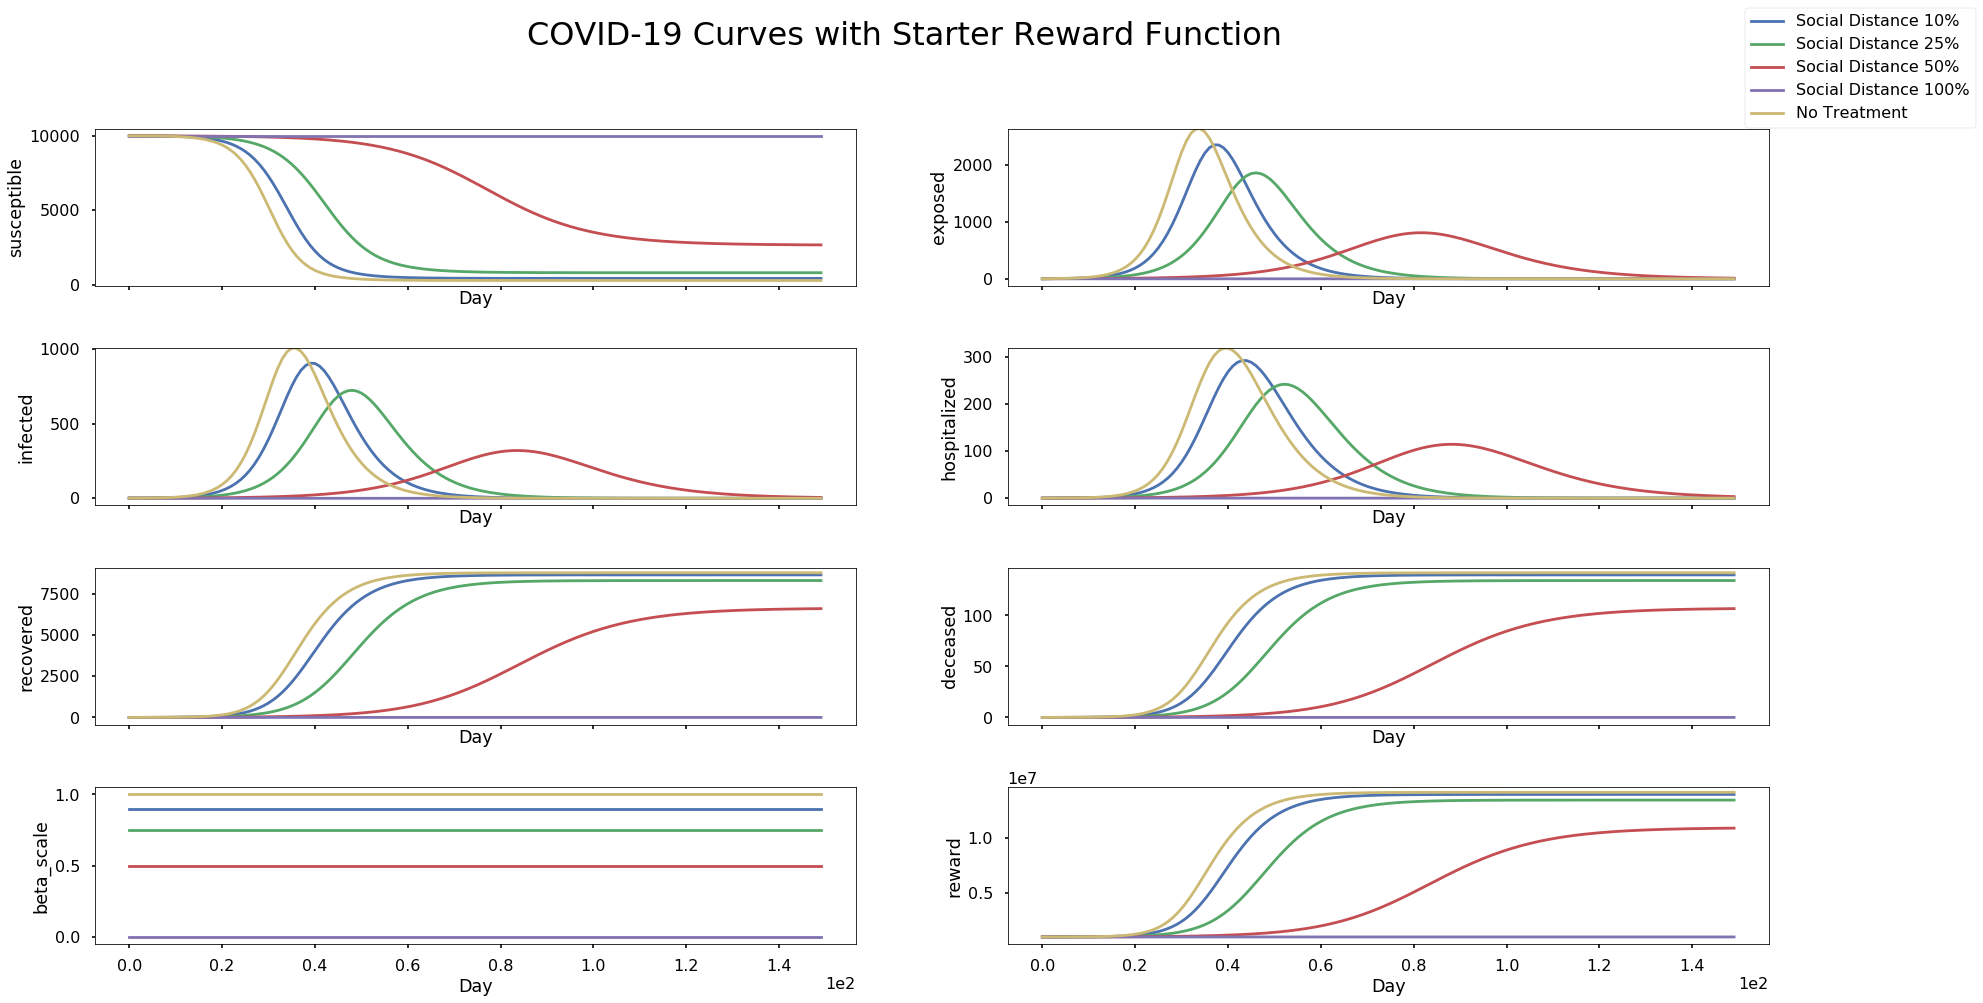

In [14]:
plot_sample_trajectory(env, augment_policies(policies, NoTreatmentPolicy(), policy_name="No Treatment"), "COVID-19 Curves with Starter Reward Function")

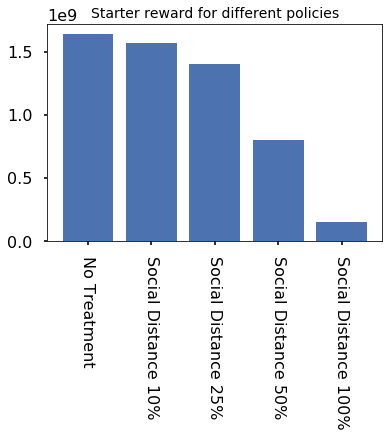

In [15]:
plot_reward_bars(env, augment_policies(policies, NoTreatmentPolicy(), policy_name="No Treatment"), "Starter reward for different policies")

### Comparison of Policies on the Basic Environment

As we can see, with no associated costs for implementing social distancing, the best option for us is to perform 100% Social Distancing - this ensures that nobody transitions beyond the susceptible stage, and has the highest reward.

However, for more practical policies, we can observe that even a difference from 10% to 25% social distancing flattens the curve significantly more. 

## Introduction of a Confounder

<img style="float: center;" src="figs/confounder.png">

We now wish to demonstrate the effect of an unobserved confounder on reinforcement learning. In the examples that follow we have **location** as an unobserved confounder. Our action space still remains the same: the strength of social distancing applied to the environment. However we now introduce two new variables to our environment:

### 1. **Impact on Policy: Non-adherence factor** 

Non-adherence is the amount of social distancing policy violation in a given environment.

### 2. **Impact on Reward: Economic cost of social distancing**

This represents the lost economic output as a function of the amount of social distancing applied

These added variables now allow us to implement a confounder that affects both the policy and the reward. To present a clearer picture, we take a simplistic example of these two fictional cities:

### 1. **Tech Haven**

A tech haven which has a high economic contribution per capita. Due to the nature of the work, furloughs and transitions to remote work are easier to implement, thereby ensuring workers adhere to social distancing policies without much effect on livelihood. 
This location would have a high adherence to social distancing policies, but also a high cost of social distancing.

### 2. **Steel Town**

A manufacturing city where economic contribution per capita is comparitively low. Steel plants play a central role in the economy - making remote work impossible, and forcing workers that rely on a daily wage to make ends meet to go into work, thereby violating social distancing policies.
This location would have lower adherence to social distancing policies, but a low cost of social distancing.

## Implementation of the Confounder

### Confounded action space

Our non-adherence is implemented as a function of the social distancing levied on a location. We can imagine that if no social distancing is applied, there is zero non-adherence. Accordingly, we define a non-adherence factor ($\eta$) as follows:

$$\text{current social distancing} = \text{current social distancing}(1 - \eta)$$

$\eta = 0.1$ for **Steel Town** and $\eta = 0.01$ for **Tech Haven**

### Confounder Reward

A reward function that weighs the costs and benefits of controlling COVID-19.

$$\text{reward} = \text{value of individual} * (\text{-state.deceased + state.susceptible}) - \text{economic output per time} * \text{current social distancing}$$

This reward function is a simple linear function that aims to minimize deaths from the virus, as well as the cost of controlling its spread.

## Implications of the Confounder

We will explore the effect of a confounder by first artificially fixing its value (thereby indirectly adjusting for the given level of confounder), and then having it vary probabilistically. We expect to see that when we fix the level of the confounder, our agent will learn an optimal policy for the given level of the confounder. However, in real life, we do not have a way to adjust for a causal confounder in reinforcement learning. Therefore, the policy learned when we don't account for the confounder will do disproportionately worse than the adjusted policies on these environments.

## Fixing the Confounder Levels

## Let's look at Tech Haven

In this environment, there there is a cost to losing people to COVID, but there is a much higher cost associated with social distancing because of the high economic output of this place - so social distancing is very expensive in this location.

Once we train our policy on this specific environment, we hope to see the policy learning to avoid stricter social distancing rules, while keeping the spread in check.

In [16]:
import simulators.covid19.environments.rich_place_env

In [17]:
rich_env = gym.make('COVID19-RICH-v0')
rich_env.seed(1);


## Policy Gradient Agent

### A simple overview of a Policy Gradient implementation:

For a given state $s$, a policy can be written as a probability distribution $\pi_\theta(s, a)$ over actions $a$, where $\theta$ represents the parameters the policy.

The objective here is to learn a $\theta^*$ that maximizes the objective function

   $\;\;\;\; J(\theta) = E_{\tau \sim \pi_\theta}[r(\tau)]$,

where $\tau$ is the trajectory sampled according to policy $\pi_\theta$ and $r(\tau)$ is the discounted sum of rewards on $\tau$.

The policy gradient approach is to take the gradient of this objective

$\nabla_{\theta} J (\theta)\\
= \nabla_{\theta} \int\pi_{\theta}(\tau)r(\tau)d\tau\\
 = \int\pi_{\theta}(\tau) \nabla_{\theta} \log\pi_{\theta}(\tau)r(\tau)d\tau\\
= E_{\tau \sim \pi\theta(\tau)}[\nabla_\theta \log \pi_\theta(\tau)r(\tau)] $

In [18]:
rich_learned_policy = utils.run_training_loop(env=rich_env, n_iter=n_iter, max_episode_length=150, batch_size=1000, learning_rate=1e-3)

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****


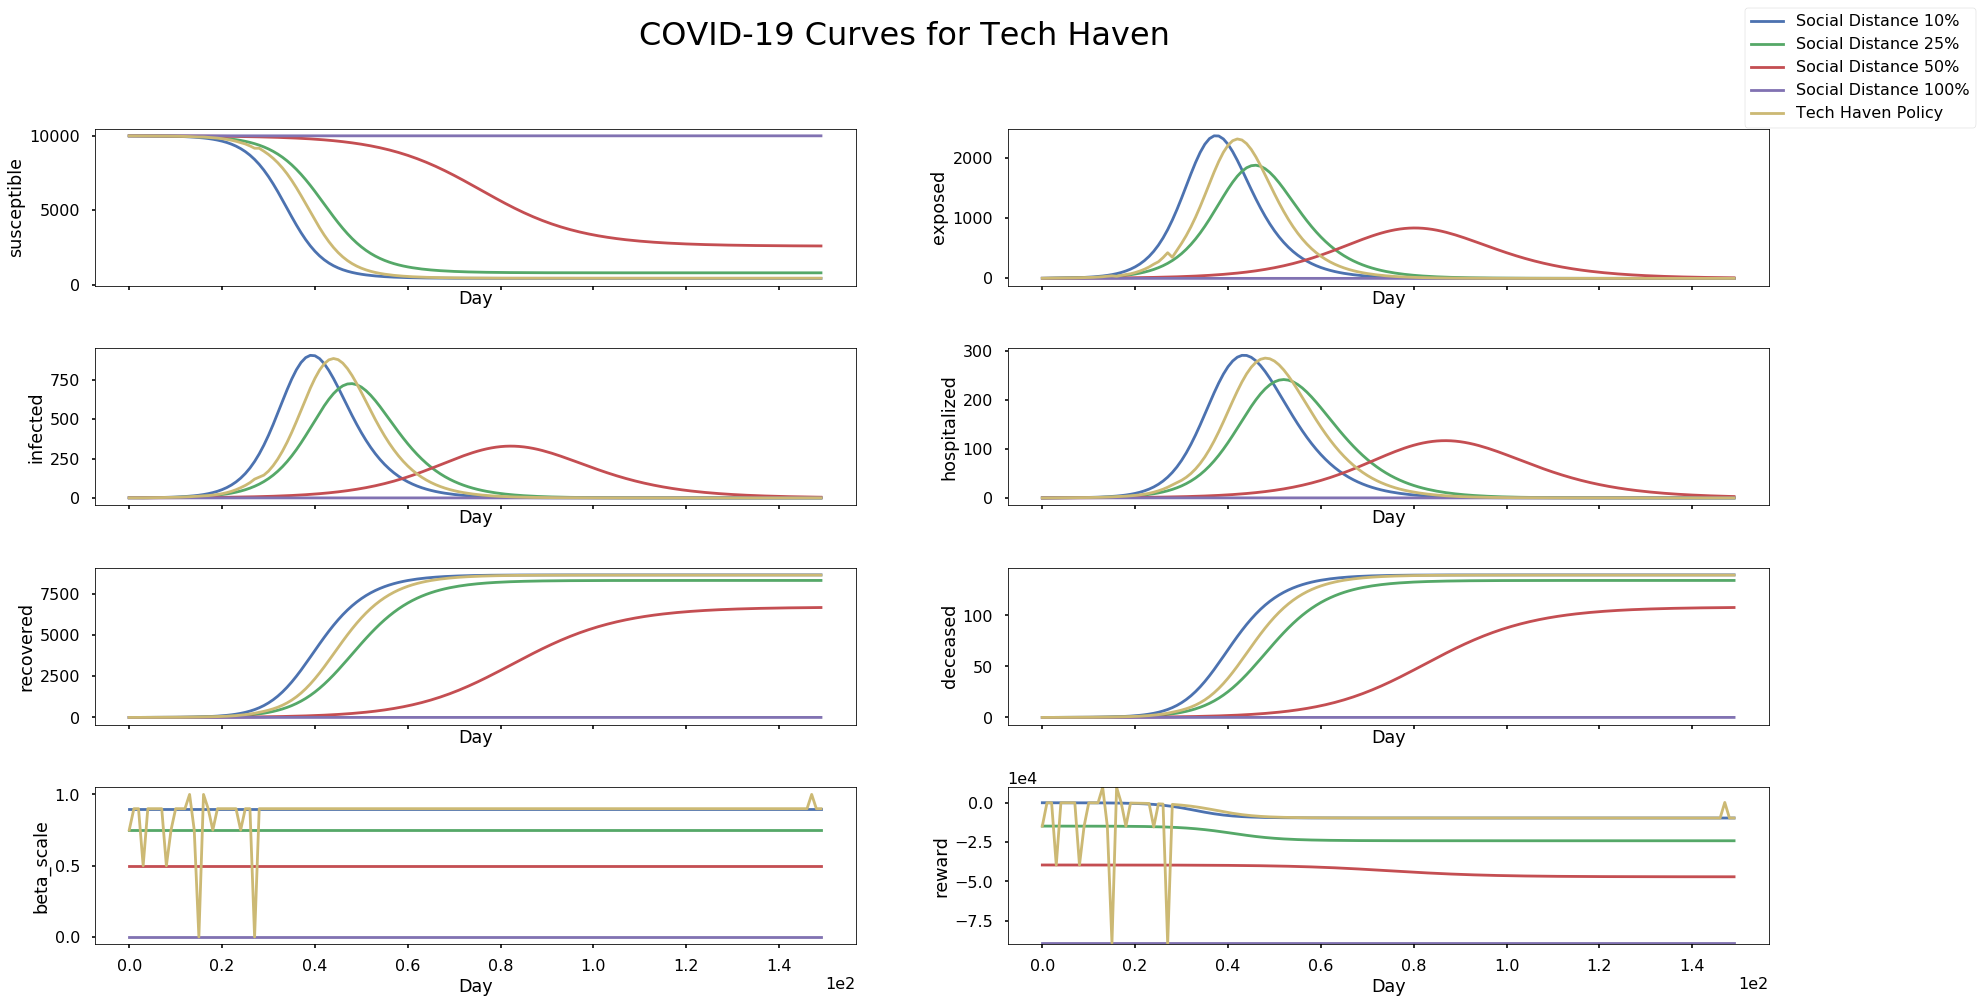

In [19]:
plot_sample_trajectory(rich_env, augment_policies(policies, rich_learned_policy, "Tech Haven Policy"), "COVID-19 Curves for Tech Haven")

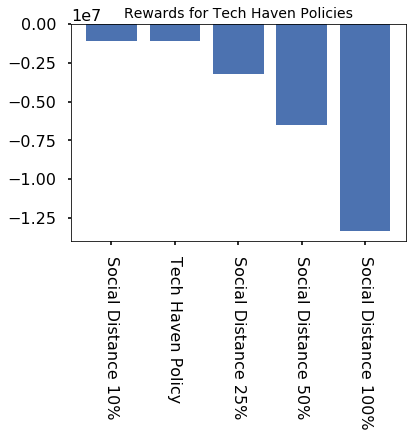

In [20]:

plot_reward_bars(rich_env, augment_policies(policies, rich_learned_policy, "Tech Haven Policy"), "Rewards for Tech Haven Policies")

### As anticipated, our agent learns that the best policy for Tech Haven is to perform almost no social distancing. It also has the highest reward among our static policies.

## Now, we look at Steel Town

This place has the same human cost - that is the cost of an individual dying, however this location does not produce nearly as much economic output and so it can afford social distancing practices and we see that the model learns that

In [21]:
import simulators.covid19.environments.poor_place_env

In [22]:
poor_env = gym.make('COVID19-POOR-v0')
poor_env.seed(1);

In [23]:
poor_learned_policy = utils.run_training_loop(env=poor_env, n_iter=n_iter, max_episode_length=150, batch_size=1000, learning_rate=1e-3)

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****


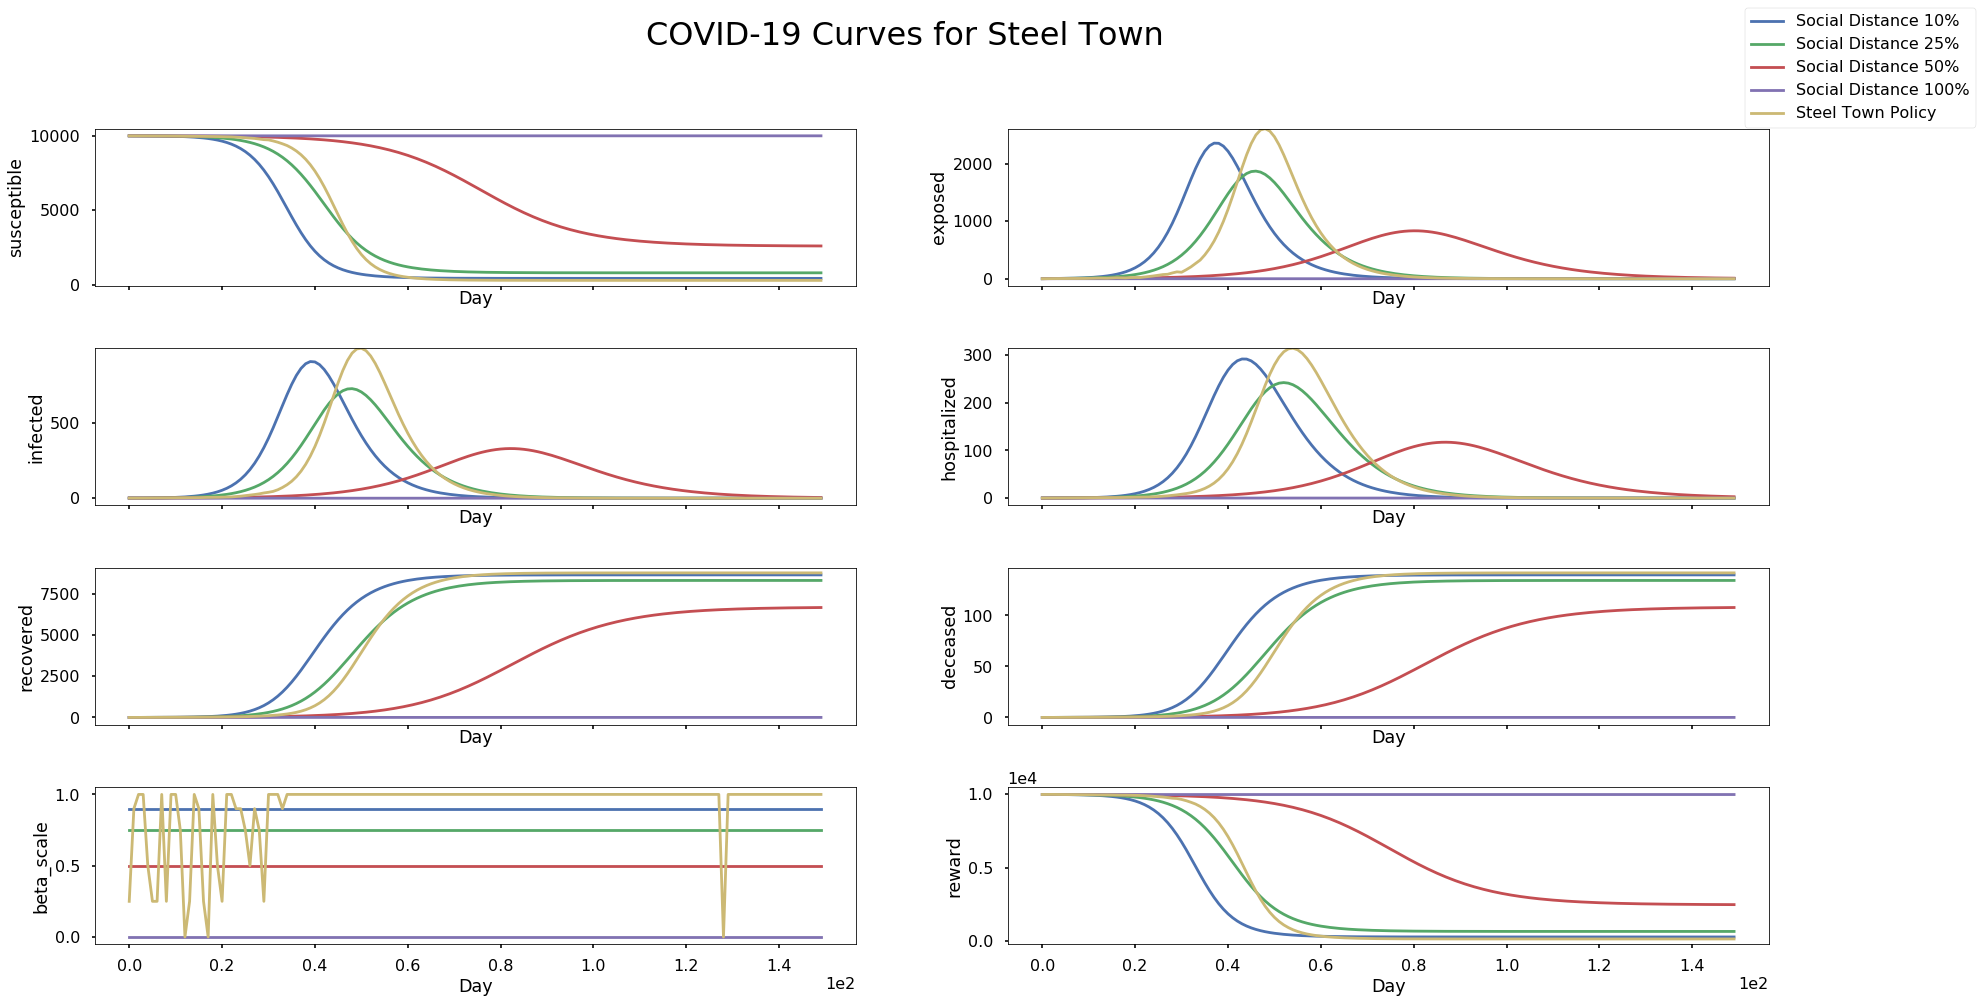

In [24]:
plot_sample_trajectory(poor_env, augment_policies(policies, poor_learned_policy, "Steel Town Policy"), "COVID-19 Curves for Steel Town")

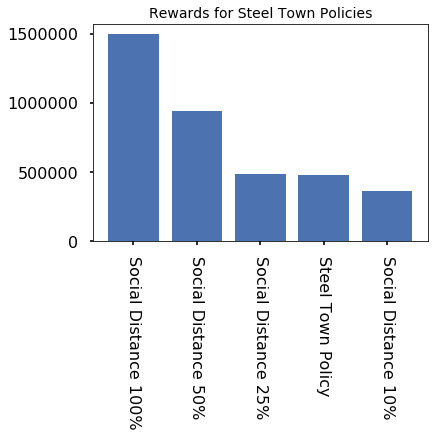

In [25]:
plot_reward_bars(poor_env, augment_policies(policies, poor_learned_policy, "Steel Town Policy"), "Rewards for Steel Town Policies")

### For Steel Town, our learned policy balances curtailing the spread of COVID with the (low) economic cost of implementing social to implement a policy that is almost as strict as 100% social distancing, but realistic in allowing for some economic contribution.

## Varying Locations

Finally, we train our agent on an envrionment where confounder values (locations) vary probabilistically.

In [26]:
import simulators.covid19.environments.confounded_env

In [27]:
confounded_env = gym.make('COVID19-CONFOUNDED-v0')
confounded_env.seed(1);

In [28]:
confounded_learned_policy = utils.run_training_loop(env=confounded_env, n_iter=n_iter, max_episode_length=150, batch_size=1000, learning_rate=1e-3)

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****


## Confounder Effect

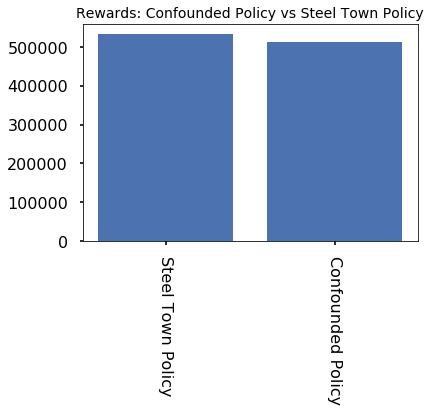

In [29]:
augmented_policies = augment_policies({}, confounded_learned_policy, policy_name='Confounded Policy')
plot_reward_bars(poor_env, augment_policies(augmented_policies, poor_learned_policy, policy_name='Steel Town Policy'),'Rewards: Confounded Policy vs Steel Town Policy')

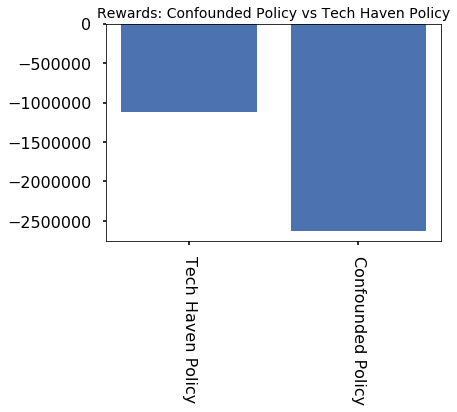

In [30]:
plot_reward_bars(rich_env, augment_policies(augmented_policies, rich_learned_policy, policy_name='Tech Haven Policy'),'Rewards: Confounded Policy vs Tech Haven Policy')

### As we can see from these reward plots, a confounded policy that does not adjust for a causal confounder does disproprortionately worse than policies trained on fixed levels of the confounder for both Steel Town and Tech Haven. This suggests an interesting area of exploration in Reinforcement Learning - studying the causal structures of problems to help optimize decision making.

References:

1. https://wwwnc.cdc.gov/eid/article/26/6/20-0233_article
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6332839/